In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from fastai.vision import *

### Data

In [ ]:
#path = Path('D:\College\BE\BE PROJECT\COVID-19-master\X-Ray_Image_DataSet')
path = Path('/content/drive/MyDrive/Dataset')

In [ ]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from fastai.vision.transform import get_transforms
#check to remove gettransforms
np.random.seed(41)
#data = ImageDataBunch.from_folder(path,  test='/content/drive/MyDrive/X-Ray_Image_DataSet/test',
#        ds_tfms=get_transforms(), size=(256,256), bs=32, num_workers=4).normalize()
#data = ImageDataBunch.from_folder(path, train='D:\\College\\BE\\BE PROJECT\\COVID-19-master\\X-Ray_Image_DataSet\\train', test='D:\\College\\BE\\BE PROJECT\\COVID-19-master\\X-Ray_Image_DataSet\\test', valid_pct=0.2, ds_tfms=get_transforms(), size=(256,256),bs=32).normalize()
data = ImageDataBunch.from_folder(path, train='/content/drive/MyDrive/DataSet/train', test='/content/drive/MyDrive/Dataset/test',ds_tfms = get_transforms() ,valid_pct=0.2, size=(256,256),bs=64).normalize()

In [ ]:
print(data)

ImageDataBunch;

Train: LabelList (2412 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
No_findings,No_findings,No_findings,No_findings,No_findings
Path: /content/drive/MyDrive/Dataset;

Valid: LabelList (602 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Covid-19,Covid-19,No_findings,Covid-19,No_findings
Path: /content/drive/MyDrive/Dataset;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: /content/drive/MyDrive/Dataset


In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_findings', 'Pneumonia'], 3, 2412, 602)

In [ ]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 2412
Number of examples in validation: 602


---

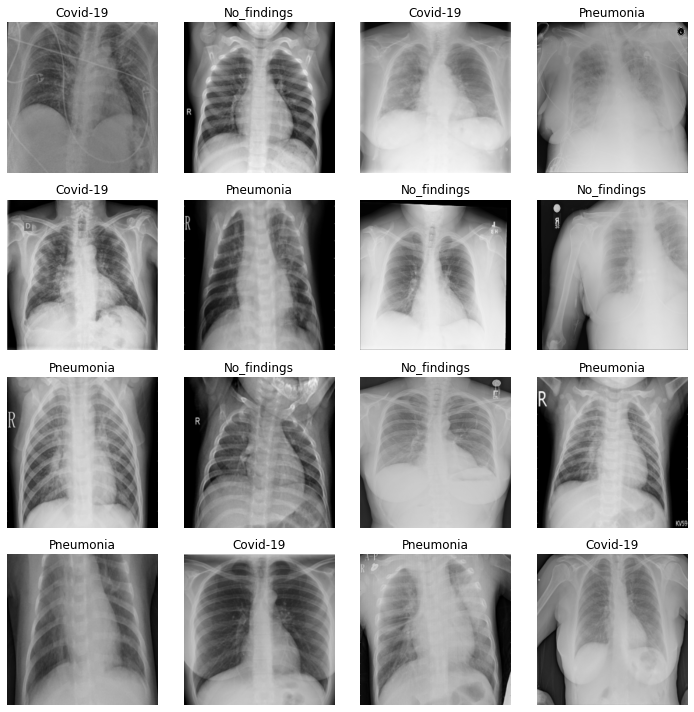

In [ ]:
data.show_batch(rows=4, figsize=(10,10))

## DarkCovidNet (modified Darknet model)

In [ ]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )

In [ ]:
def triple_conv(ni, nf):
    return nn.Sequential(conv_block(ni, nf),conv_block(nf, ni, size=1),conv_block(ni, nf)
    )

In [ ]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

In [ ]:
model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_layer(256, 3),
    Flatten(),
    nn.Linear(507, 3),
    nn.Softmax(dim=1)
)

In [ ]:
learn = Learner(data,model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [ ]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
LeakyReLU            [8, 256, 256]        0          False     
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
LeakyReLU            [16, 128, 128]       0          False     
___________________________________________________

In [ ]:
#learn.lr_find(stop_div=False, num_it=200)

In [ ]:
#learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(100, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.880985,1.041947,0.506645,01:00
1,0.788895,0.732416,0.838870,01:00
2,0.724566,0.715464,0.855482,01:01
3,0.673431,0.703413,0.867110,01:00
4,0.637410,0.685242,0.878738,01:00
5,0.617583,0.746607,0.808970,01:00
6,0.618808,0.763728,0.777409,01:01
7,0.637411,0.745212,0.802326,01:01
8,0.644351,0.705494,0.845515,01:00
9,0.641078,0.761623,0.790698,01:01


epoch,train_loss,valid_loss,accuracy,time
0,0.880985,1.041947,0.506645,01:00
1,0.788895,0.732416,0.838870,01:00
2,0.724566,0.715464,0.855482,01:01
3,0.673431,0.703413,0.867110,01:00
4,0.637410,0.685242,0.878738,01:00
5,0.617583,0.746607,0.808970,01:00
6,0.618808,0.763728,0.777409,01:01
7,0.637411,0.745212,0.802326,01:01
8,0.644351,0.705494,0.845515,01:00
9,0.641078,0.761623,0.790698,01:01


AttributeError: ignored

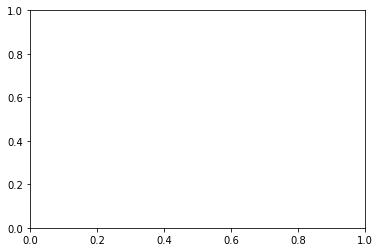

In [ ]:
learn.recorder.plot_losses()

In [ ]:
print("Number of examples in testing:", len(data.valid_ds))

Number of examples in testing: 602


In [ ]:
probs,targets = learn.get_preds(ds_type=DatasetType.Valid) 

In [ ]:
accuracy(probs,targets)

TypeError: ignored

In [ ]:
probs = np.argmax(probs, axis=1)
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print(len(probs), correct, accuracy*100)


from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Covid-19', 'No_findings', 'Pneumonia']
print(classification_report(y_true1, y_pred1, target_names=target_names))

602 545 90.53156146179401
              precision    recall  f1-score   support

    Covid-19       0.98      0.96      0.97       202
 No_findings       0.89      0.88      0.89       211
   Pneumonia       0.84      0.87      0.86       189

    accuracy                           0.91       602
   macro avg       0.91      0.90      0.90       602
weighted avg       0.91      0.91      0.91       602



In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

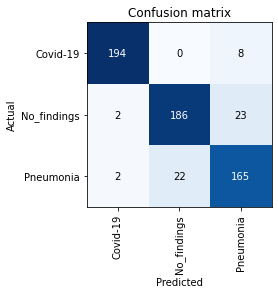

In [ ]:
cm_fig = interp.plot_confusion_matrix(return_fig=True)

In [ ]:
learn.export()

In [ ]:
learn.save()